In [1]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [2]:
train_data.shape

(404, 13)

In [3]:
test_data.shape

(102, 13)

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [5]:
from tensorflow.keras import layers
from tensorflow.keras import models

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

In [6]:
# k-fold validation
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

In [7]:
for i in range(k):
    print(f"Processing fold #{i}")
    
    # prepare the validation data from partition k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]        
    val_label = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # prepare the training data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples], 
         train_data[(i + 1) * num_val_samples:]], 
        axis=0)         
    partial_train_label = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]], 
        axis=0)
    
    # build the model
    model = build_model() 
    
    # train the model in silent mode
    model.fit(partial_train_data, partial_train_label, 
              epochs = num_epochs,
              batch_size = 1,
              verbose=0)
    
    # evaluate the model with the evaluation set
    val_mse, val_mae = model.evaluate(val_data, val_label, verbose=0)
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [8]:
all_scores

[1.9095274209976196, 2.4868099689483643, 2.8998489379882812, 2.668783664703369]

In [9]:
np.mean(all_scores)

2.4912424981594086

In [10]:
#Try again with 500 epochs
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print(f"Processing fold #{i}")
    
    # prepare the validation data from partition k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]        
    val_label = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    # prepare the training data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples], 
         train_data[(i + 1) * num_val_samples:]], 
        axis=0)         
    partial_train_label = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]], 
        axis=0)
    
    # build the model
    model = build_model() 
    
    # train the model in silent mode
    history = model.fit(partial_train_data, partial_train_label, 
            validation_data = (val_data, val_label),
            epochs = num_epochs,
            batch_size = 1,
            verbose=0)
    
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [11]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

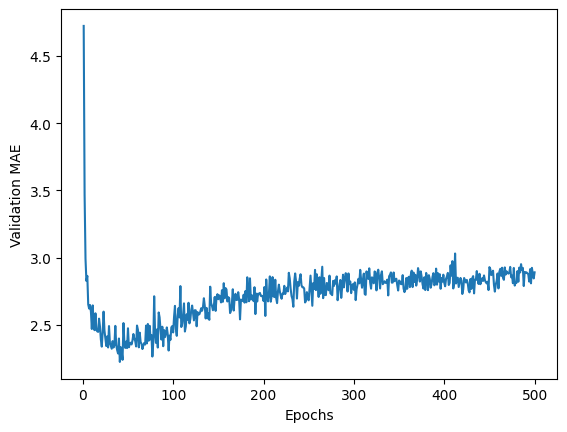

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


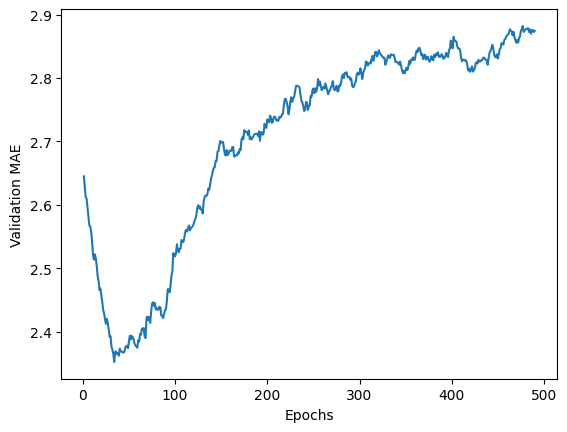

In [13]:

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [14]:
# tweak hyperparameters

# build the model
model = build_model() 
    
    # train the model in silent mode
model.fit(train_data, train_targets, 
              epochs = 80,
              batch_size = 12,
              verbose=0)
    
    # evaluate the model with the evaluation set
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets, verbose=0)
test_mae_score

2.582517147064209